In [1]:
# General imports
import numpy as np
import pandas as pd

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import Z2Symmetries

# SciPy minimizer routine
from scipy.optimize import minimize

# imort NUmpy algorithm to solve minumun energy exactly
from qiskit_algorithms import NumPyEigensolver

# Plotting functions
import matplotlib.pyplot as plt

# runtime imports 1.0 qiskit properties
#from qiskit_ibm_runtime import QiskitRuntimeService, Session
#from qiskit_ibm_runtime import EstimatorV2 as Estimator

from qiskit.primitives import Estimator,BackendEstimator,StatevectorEstimator

from qiskit.providers.fake_provider import GenericBackendV2 # qiskit 1.0 property
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager # qiskit 1.0 property

# qiskit_nature imports
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper,QubitMapper,TaperedQubitMapper # QubitMapper is the new QubitConverter/FermionicTransformation
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD


In [386]:
# Create the chemistry molecules
nh3 = 0.5

molecules = {
    "H2": MoleculeInfo(
        symbols=["H","H"],
        coords=[(0.0, 0.0, 0.0), (0.0, 0.0, 0.75)],
        charge=0,
        multiplicity=1,
    ),
    "LiH": MoleculeInfo(
        symbols=["Li","H"],
        coords=[(0.0, 0.0, 0.0),(0.0, 0.0, 1.6)],
        charge=0,
        multiplicity=1,
    ),
    "H2O": MoleculeInfo(
        symbols = ["O", "H", "H"],
        coords=[(0.0,0.0,0.0),(0.757, 0.586, 0.0),(-0.757, 0.586, 0.0)],
        charge=0,
        multiplicity=1,
    ),
    "NH3": MoleculeInfo(
        symbols=["N","H","H","H"],
        coords=[(0.0,0.0,0.0),(0.0, 0.0, 0.0),(0.0, 0.0, 0.0),(0.0, 0.0, 0.0)],
        charge=0,
        multiplicity=1,
    ),
    "He": MoleculeInfo(
        symbols=["He"],
        coords=[(0.0,0.0,0.0)],
        charge=0,
        multiplicity=1,
    )
}

def prepare_hamiltonian(
    molecule, z2symmetry_reduction, mapping,freeze_core=True, basis='sto-3g'
):  
    """Creates the Hamiltoanin for a molecule with given mapping 
    
    Args: molecule: (MoleculeInfo object)
          z2symmetry_reduction: (bool) whether to reduce the Hamiltonian using Z2 symmetries
          mapping: (str) the mapping to use
          freeze_core: (bool) whether to freeze the core orbitals
          basis: (str) the basis set to use
    Returns: qubitOp: (SparsePauliOp) the Hamiltonian as a (paulis=[],coeff=[])"""

    # Uses a global variable `molecules` defined above
    molecule = molecules[molecule]

    # Execute the PySCF driver
    driver = PySCFDriver.from_molecule(molecule=molecule, basis=basis)

    if mapping == "parity":
        #qubit_mapping = FermionicQubitMappingType.PARITY
        qubit_mapping = ParityMapper()
    elif mapping == "bravyi_kitaev":
        #qubit_mapping = FermionicQubitMappingType.BRAVYI_KITAEV
        qubit_mapping = BravyiKitaevMapper()
    #elif mapping == "neven":
    #    qubit_mapping = FermionicQubitMappingType.NEVEN
    elif mapping == "jordan_wigner":
        #qubit_mapping = FermionicQubitMappingType.JORDAN_WIGNER
        qubit_mapping = JordanWignerMapper()
    else:
        raise ValueError("Wrong mapping")
    total_hamiltonian = driver.run()
    #total_hamiltonian = problem.hamiltonian.second_q_op()
    
    total_number_of_orbitals = 6

    # Apply the freeze core transformation
    transformer = FreezeCoreTransformer(freeze_core=freeze_core)
    transformer.prepare_active_space(molecule,total_number_of_orbitals)
    reduced_hamiltonian = transformer.transform(total_hamiltonian)

    # Convert the Hamiltonian to second quantized form
    hamiltonian = reduced_hamiltonian.hamiltonian.second_q_op()
    
    # Apply the given fermion to Pauli encoding
    qubitOp = QubitMapper.map(self=qubit_mapping,
        second_q_ops=hamiltonian
        )
    
    # Apply Z2 symmetries (except for hydrogen)
    if molecule is not 'H2':
        if z2symmetry_reduction:
            z2symmetries = Z2Symmetries.find_z2_symmetries(qubitOp)
            qubitOp = z2symmetries.taper(qubitOp)
    
    return qubitOp[0]


#LiH = prepare_hamiltonian(molecule='LiH', z2symmetry_reduction=True, freeze_core=True, mapping='parity',basis='sto-3g')
#H2 = prepare_hamiltonian(molecule='H2', z2symmetry_reduction=False, freeze_core=True, mapping='parity',basis='sto-3g')
#H2O = prepare_hamiltonian(molecule='H2O', z2symmetry_reduction=True, freeze_core=True, mapping='parity',basis='sto-3g')

<>:87: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
<>:87: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
/tmp/ipykernel_1611075/1827189353.py:87: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if molecule is not 'H2':


In [382]:
# Pauli string weight calculator
def pauli_weight(pauli_string):
    """Caclulates the Pauli weight of a given Pauli string (NUmber of Pauyli operators in a string). This method calculates the theoretical value if circut can execute
        X, Y and Z in on operation.
        
    Args:
        pauli_string (str): Pauli string
    Returns:
            Pauli Weight (int)"""
    weight = 0
    for oper in str(pauli_string):
        if oper == 'Z' or oper == 'X' or oper == 'Y':
            weight += 1
    return weight

def hardware_pauli_weight(pauli_string):
    """This calculates the weight of a Pauli string that can be executed on the RZ based Quantum circuit. Z and I do not add any Pauli weight,
        , but X adds two and Y adds 4.

        Args: pauli_string (str): Pauli string
        Returns: Pauli Weight (int)"""
    weight = 0
    for oper in str(pauli_string):
        # To measure X, we need to apply Hadamard gate, and in actaul circuit H = Rz(theta1)*Rz(theta2)
        if oper == 'X':
            weight += 2
        # To measure Y we need to apply Sdg gate, and in actual circuit SH = 
        elif oper == 'Y':
            weight += 4
    return weight

def build_ansatz(ansatz_name,mapper,num_qubits,num_particles,reps):
    """Create hartreeFock anstaz with selected parametrization

    Args: ansatz_name (str): name of the ansatz
          mapper (str): name of the mapper
          num_qubits (int): number of qubits
          num_particles (int): number of particles
          reps (int): number of repetitions
          
    Returns: ansatz (QuantumCircuit): ansatz circuit"""
    
    if mapper == 'parity':
        qubit_mapping = ParityMapper()
    elif mapper == 'bravyi_kitaev': 
        qubit_mapping = BravyiKitaevMapper()
    elif mapper == 'jordan_wigner':
        qubit_mapping = JordanWignerMapper()
    # elif mapper == 'neven':
    #     qubit_mapping = FermionicQubitMappingType.NEVEN
    else:
        raise ValueError('Invalid mapper name')

    # Spin is zero for our molecules, so there is equal number of alpha and beta particles
    alpha = int(num_particles/2)
    beta =  int(num_particles/2)

    # create HartreeFock state
    hf_state = HartreeFock(num_spatial_orbitals=int(num_qubits/2), num_particles=(alpha,beta), qubit_mapper=qubit_mapping)

    if ansatz_name=='UCCSD':
        ansatz = UCCSD(num_spatial_orbitals=int(num_qubits/2), num_particles=(alpha,beta), qubit_mapper=qubit_mapping)
    elif ansatz_name=='EfficientSU2':
        ansatz = EfficientSU2(num_qubits=int(num_qubits), entanglement='linear', reps=reps)
    else: 
        raise ValueError('Invalid ansatz name')

    return hf_state.compose(ansatz)

# Initialize the cost history dictionary
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "vectors": [],
    }

def cost_func(params, ansatz, hamiltonian, estimator,cost_history_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(ansatz,hamiltonian,params).result()
    energy = result.values

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    cost_history_dict["vectors"].append(params)
    #print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy
    #optimize the ansatz for backend

def vqe(num_qubits,ansatz,hamiltonian):
    """Run the VQE optimization algorithm. This function uses the COBYLA optimizer from SciPy. 

    Args: num_qubits (int): number of qubits
          ansatz (QuantumCircuit): ansatz circuit
          hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
    Returns: cost_history_dict (dict): dictionary containing the cost and parameter history of the optimization"""
    
    # Get the backend
    backend = GenericBackendV2(num_qubits)
    
    # Get the number of parameters in the ansatz
    num_params = ansatz.num_parameters
    
    # Optimize the ansatz for the backend
    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

    cost_history_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
        "vectors": [],
    }
    #x0 = 2 * np.pi * np.random.random(num_params)
    x0 = np.zeros(num_params)

    estimator = BackendEstimator(backend)
    estimator.options.default_shots = 10_000
    # set the maximum number of iterations
    options = {'maxiter': 200}

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator,cost_history_dict),
        method="cobyla",
        options=options,
    )
    return cost_history_dict

In [384]:
# !!!!!! RUNNING EVERYTHING TAKES ~500 MINUTES !!!!!!!  
 
mappers = ['parity','bravyi_kitaev', 'jordan_wigner']
ansatzes = ['EfficientSU2']#,'UCCSD']
molecule_names = ['LiH']#, 'H2O']#,'H2'] # hydrogen molecule is not included because it causes problems with z2symmetries
Z2Symmetries_list = [True]#,False]

default_map = ['jordan_wigner']
default_ansatz = ['EfficientSU2']
default_Z2Symmetries = [True]
defaulöt_measuremnt_scene = ['pauli_scheme']

# Create a pandas DataFrame to store the Hamiltonians
data = pd.DataFrame(columns=['molecule','z2Symmetries', 'mapping', 'ansatz','ansatz_circuit', 'hamiltonian','avg_pauli_weight','avg_hardware_pauli_weight','num_pauli_strings','num_qubits','vqe_energies','iterations','exact_energies','exact_solution','parameters','error'])


In [362]:
# Iterate over all different parameters and store the results in the DataFrame named data
for map in mappers:
    for z2sym in Z2Symmetries_list:
        for molecule in molecule_names:
            for ansatz in ansatzes:
            
                # create the problem hamiltonian
                hamiltonian = prepare_hamiltonian(molecule=molecule, z2symmetry_reduction=z2sym, freeze_core=True, mapping=map)
            
                # retrieve and calculate some useful information
                num_qubits = hamiltonian.num_qubits
                num_pauli_strings = len(hamiltonian.paulis)
                avg_pauli_weight = np.mean([pauli_weight(pauli) for pauli in hamiltonian.paulis])
                avg_hardware_pauli_weight = np.mean([hardware_pauli_weight(pauli) for pauli in hamiltonian.paulis])
            
                # create the ansatz circuit
                ansatz_circuit = build_ansatz(ansatz_name=ansatz, mapper=map, num_qubits=num_qubits, num_particles=2, reps=2)
            
                # perform the vqe calculation
                vqe_results = vqe(num_qubits,ansatz_circuit,hamiltonian)
                vqe_energies = vqe_results['cost_history']
                iterations = vqe_results['iters']
                parameters = vqe_results['vectors']

                # calculate the exact energies with parameters from the vqe calculation 
                estimator = Estimator()
                exact_energies = []
                for i in range(len(parameters)):
                    exact_energies.append(estimator.run(circuits=ansatz_circuit,observables=hamiltonian,parameter_values=parameters[i]).result().values[0])
            
                # calculate the exact minumun solution
                exact_solution = np.real(NumPyEigensolver(k=1).compute_eigenvalues(hamiltonian).eigenvalues[0])

                # calculate the error of the vqe calculation
                error = [float(abs(exact_energies[i]-vqe_energies[i])) for i in range(len(vqe_energies))]

                # store the results in the DataFrame
                new_row = {'molecule':molecule, 'z2Symmetries': str(z2sym),'mapping':map, 'ansatz':ansatz,'ansatz_circuit':ansatz_circuit,
                            'hamiltonian':hamiltonian, 'avg_pauli_weight':avg_pauli_weight, 'num_pauli_strings':num_pauli_strings,
                              'num_qubits':num_qubits, 'vqe_energies':vqe_energies,'iterations':iterations,'parameters':parameters,
                              'error':error,'exact_energies':exact_energies,'exact_solution':exact_solution,'avg_hardware_pauli_weight':avg_hardware_pauli_weight}
                data.loc[len(data)] = new_row

/tmp/ipykernel_1611075/3233414064.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = [float(abs(exact_energies[i]-vqe_energies[i])) for i in range(len(vqe_energies))]
/tmp/ipykernel_1611075/3233414064.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = [float(abs(exact_energies[i]-vqe_energies[i])) for i in range(len(vqe_energies))]
/tmp/ipykernel_1611075/3233414064.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = [float(abs(exact_ene

In [363]:
# save the dataframe to a csv file
data.to_csv('hamiltonians_and_results.csv')

Because we are sending a large number of jobs that we would like to execute together, we use a [`Session`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Session) to execute all the generated circuits in one block.  Here `args` is the standard SciPy way to supply the additional parameters needed by the cost function.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


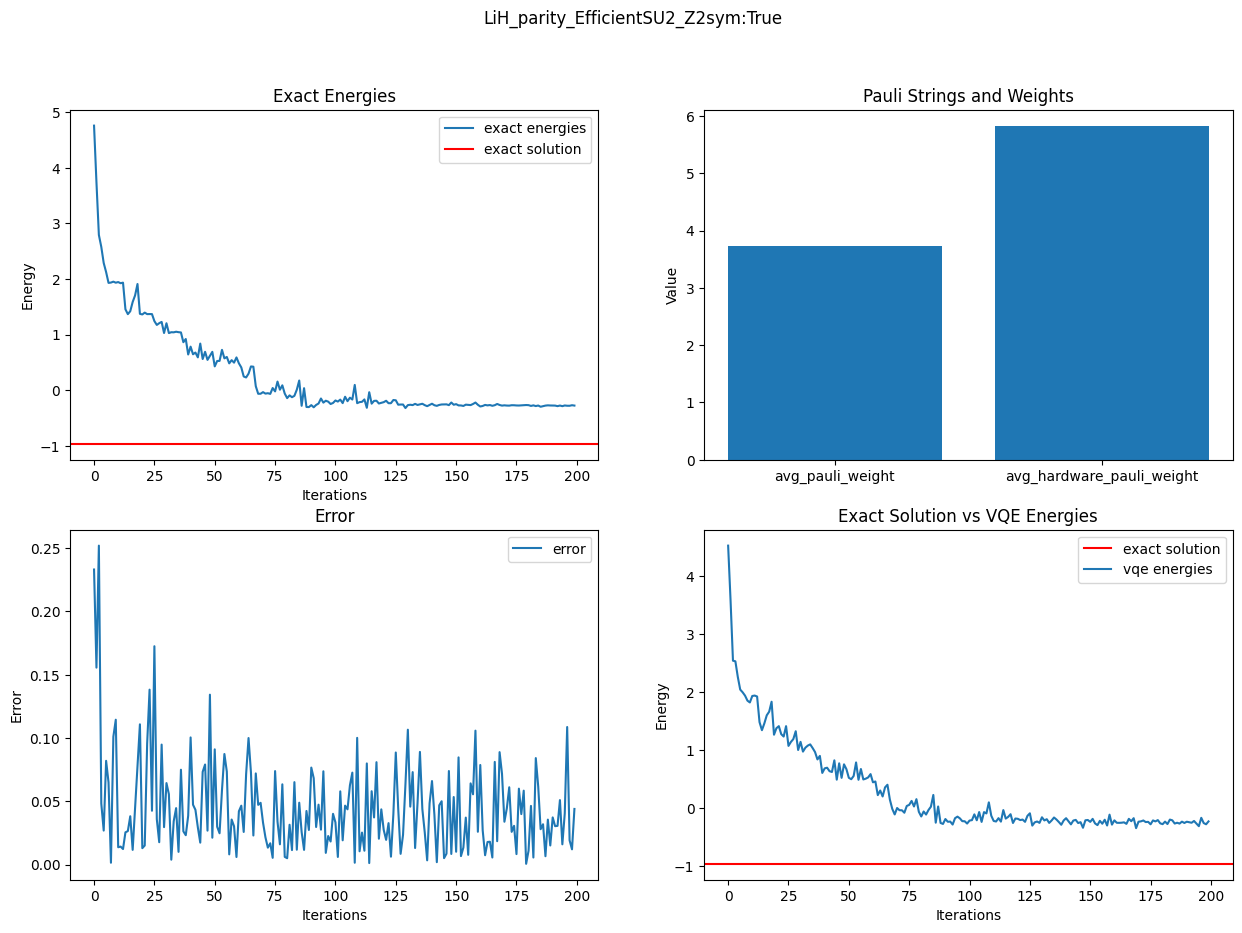

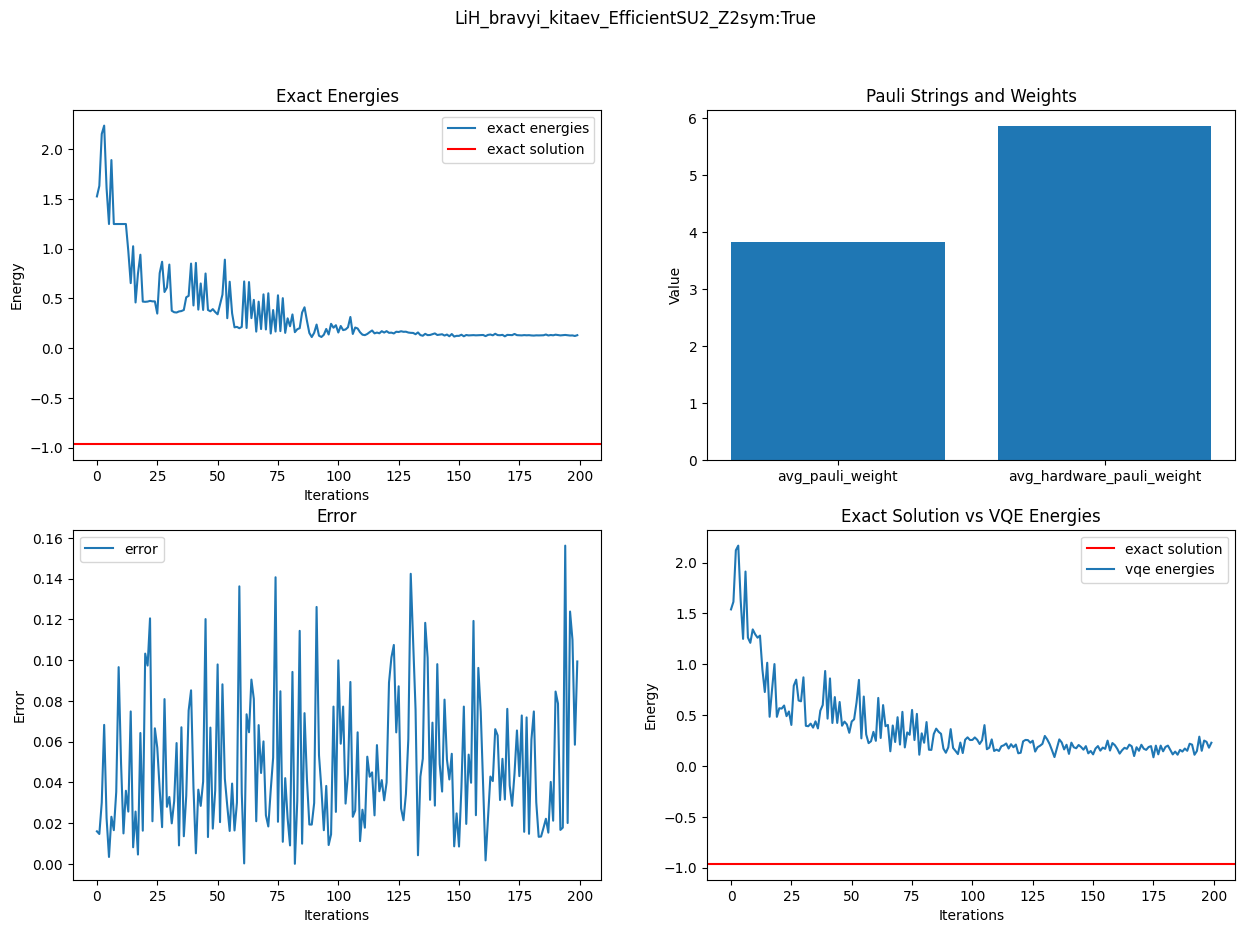

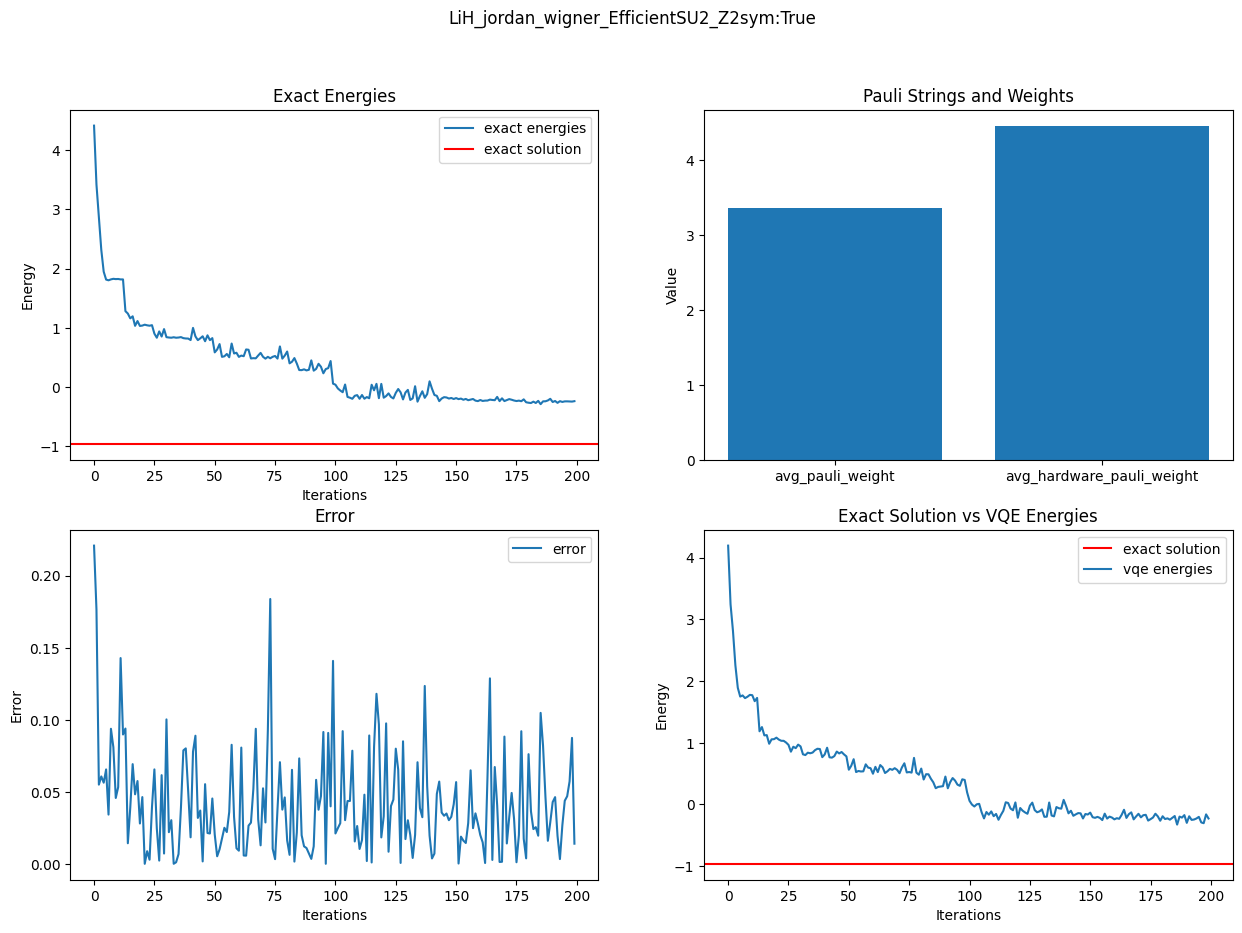

In [379]:
# plot results
for mol in molecule_names:
    for map in mappers:
        for ansatz in ansatzes:
            for z2sym in Z2Symmetries_list:
                # build the name 
                run_name = f'{mol}_{map}_{ansatz}_Z2sym:{z2sym}'
                # create subplots for each different aspect
                
                # number of qubits
                num_qubits = data[(data['molecule']==mol) & (data['mapping']==map) & (data['ansatz']==ansatz) & (data['z2Symmetries']==str(z2sym))]['num_qubits'].iloc[0]

                # number of pauli strings
                num_pauli_strings = data[(data['molecule']==mol) & (data['mapping']==map) & (data['ansatz']==ansatz) & (data['z2Symmetries']==str(z2sym))]['num_pauli_strings'].iloc[0]

                # average pauli weight
                avg_pauli_weight = data[(data['molecule']==mol) & (data['mapping']==map) & (data['ansatz']==ansatz) & (data['z2Symmetries']==str(z2sym))]['avg_pauli_weight'].iloc[0]
                
                # average hardware pauli weight
                avg_hardware_pauli_weight = data[(data['molecule']==mol) & (data['mapping']==map) & (data['ansatz']==ansatz) & (data['z2Symmetries']==str(z2sym))]['avg_hardware_pauli_weight'].iloc[0]

                # number of iterations
                iterations = data[(data['molecule']==mol) & (data['mapping']==map) & (data['ansatz']==ansatz) & (data['z2Symmetries']==str(z2sym))]['iterations'].iloc[0]

                # error
                errors = data[(data['molecule']==mol) & (data['mapping']==map) & (data['ansatz']==ansatz) & (data['z2Symmetries']==str(z2sym))]['error'].iloc[0]

                # exact solution
                exact_solution = data[(data['molecule']==mol) & (data['mapping']==map) & (data['ansatz']==ansatz) & (data['z2Symmetries']==str(z2sym))]['exact_solution'].iloc[0]

                # exact energies
                exact_energies = data[(data['molecule']==mol) & (data['mapping']==map) & (data['ansatz']==ansatz) & (data['z2Symmetries']==str(z2sym))]['exact_energies'].iloc[0]

                # vqe energies
                vqe_energies = data[(data['molecule']==mol) & (data['mapping']==map) & (data['ansatz']==ansatz) & (data['z2Symmetries']==str(z2sym))]['vqe_energies'].iloc[0]

                # Create subplots for each different aspect

                fig, axs = plt.subplots(2, 2, figsize=(15, 10))
                fig.suptitle(run_name)
                # plot the exact energies
                axs[0, 0].plot(exact_energies, label='exact energies')
                axs[0, 0].axhline(y=exact_solution, color='r', linestyle='-', label='exact solution')
                axs[0, 0].set_title('Exact Energies')
                axs[0, 0].set_xlabel('Iterations')
                axs[0, 0].set_ylabel('Energy')
                axs[0, 0].legend()
                # plot the number of pauli strings, avg pauli weights, and avg hardware pauli weights
                # Use barplots
                axs[0, 1].bar(['avg_pauli_weight', 'avg_hardware_pauli_weight'], [avg_pauli_weight, avg_hardware_pauli_weight])
                axs[0, 1].set_title('Pauli Strings and Weights')
                axs[0, 1].set_ylabel('Value')
                plt.legend()

                # plot the error
                axs[1, 0].plot(errors, label='error')
                axs[1, 0].set_title('Error')
                axs[1, 0].set_xlabel('Iterations')
                axs[1, 0].set_ylabel('Error')
                axs[1, 0].legend()
                # plot the exact solution
                axs[1, 1].axhline(y=exact_solution, color='r', linestyle='-', label='exact solution')
                axs[1, 1].plot(vqe_energies, label='vqe energies')
                axs[1, 1].set_title('Exact Solution vs VQE Energies')
                axs[1, 1].set_xlabel('Iterations')
                axs[1, 1].set_ylabel('Energy')
                axs[1, 1].legend()
                plt.savefig(f'{run_name}.png')              

In [ ]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

In [ ]:
import qiskit

qiskit.version.get_version_info()